## Notebook for the Kong 2023 QC 
### Developed by: Anna Maguza

### Institute of Computational Biology - Computational Health Centre - Hemlholtz Munich

### 4th April 2023

#### Load required packages

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#### Setup Cells

In [ ]:
%matplotlib inline

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Upload Data

In [ ]:
#Loading again to further processing
input_Normal_file = '/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Raw_anndata/Kong_2023_raw_anndata.h5ad'  # the file that will store the analysis results
output_Normal_file = '/Users/anna.maguza/Desktop/Data/Gut_project/Healthy_gut_data/Kong_2023/Raw_anndata/Kong_2023_raw_anndata_output.h5ad'  # the file that will store the analysis results

In [ ]:
#Anndata upload
adata = sc.read_h5ad(input_Normal_file)
adata.X

<720633x27830 sparse matrix of type '<class 'numpy.float32'>'
	with 729422510 stored elements in Compressed Sparse Row format>

In [ ]:
# Filter out only healthy samples
adata = adata[adata.obs['disease__ontology_label'] == 'normal']

In [ ]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)


/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [ ]:
# Make gene_id as a first column in adata.var
adata.var.insert(0, 'gene_id', adata.var.index)

### Doublets identification

In [ ]:
import scrublet

In [ ]:
scrub = scrublet.Scrublet(adata.X)

Preprocessing...


/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 56.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 695.3 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

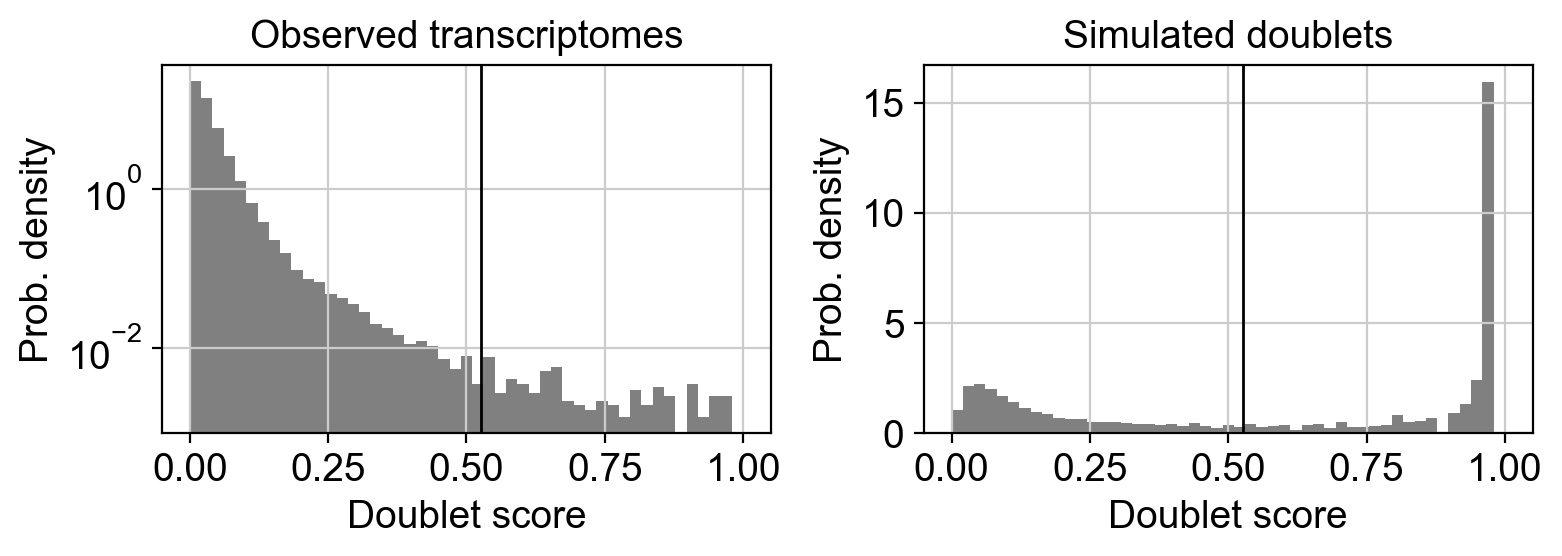

In [ ]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [ ]:
sum(adata.obs['predicted_doublets'])

232

In [ ]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

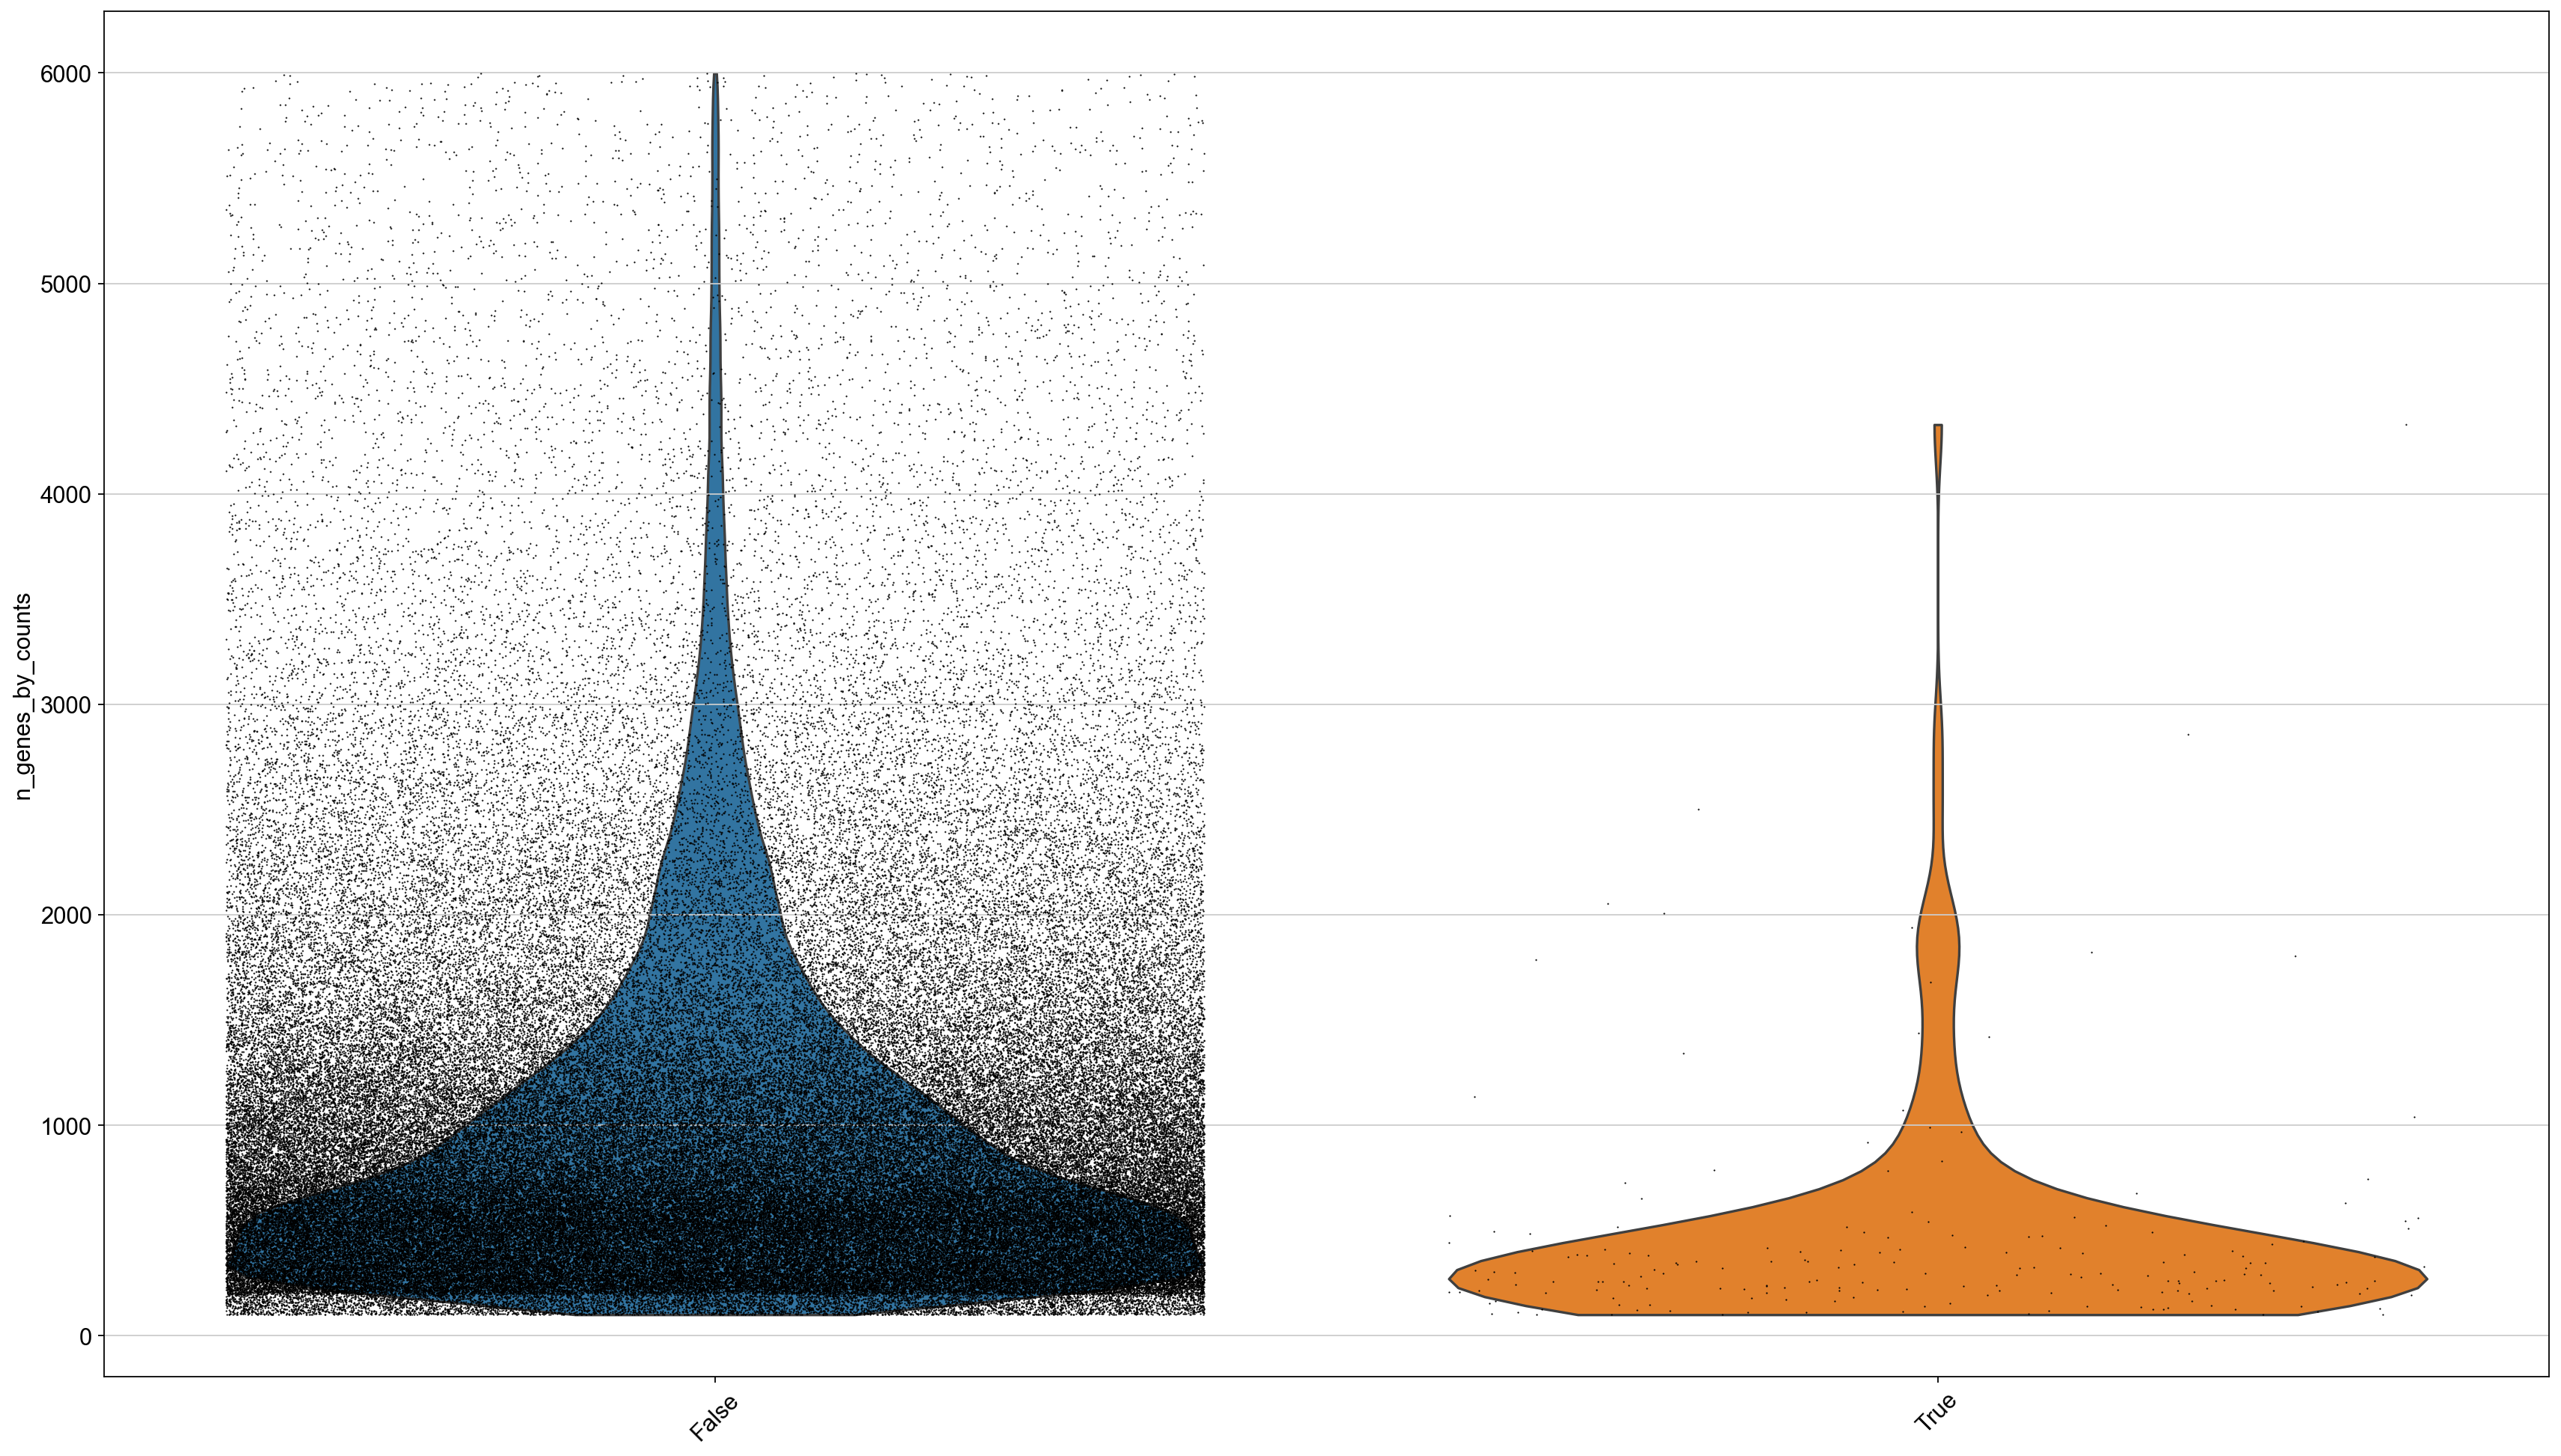

In [ ]:
#check if our predicted doublets also have more detected genes in general
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [ ]:
#Lets run PCA and UMAP and plot doublet scores onto umap to check the doublet predictions.
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata_scrublet = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata_scrublet, ['total_counts', 'pct_counts_mito'])

regressing out ['total_counts', 'pct_counts_mito']
    finished (0:02:53)


In [ ]:
sc.pp.scale(adata_scrublet, max_value=10)

In [ ]:
sc.pp.neighbors(adata_scrublet, n_neighbors = 50, n_pcs = 50)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:13)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:18)


In [ ]:
sc.tl.umap(adata_scrublet)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:12)


/Users/anna.maguza/miniconda3/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


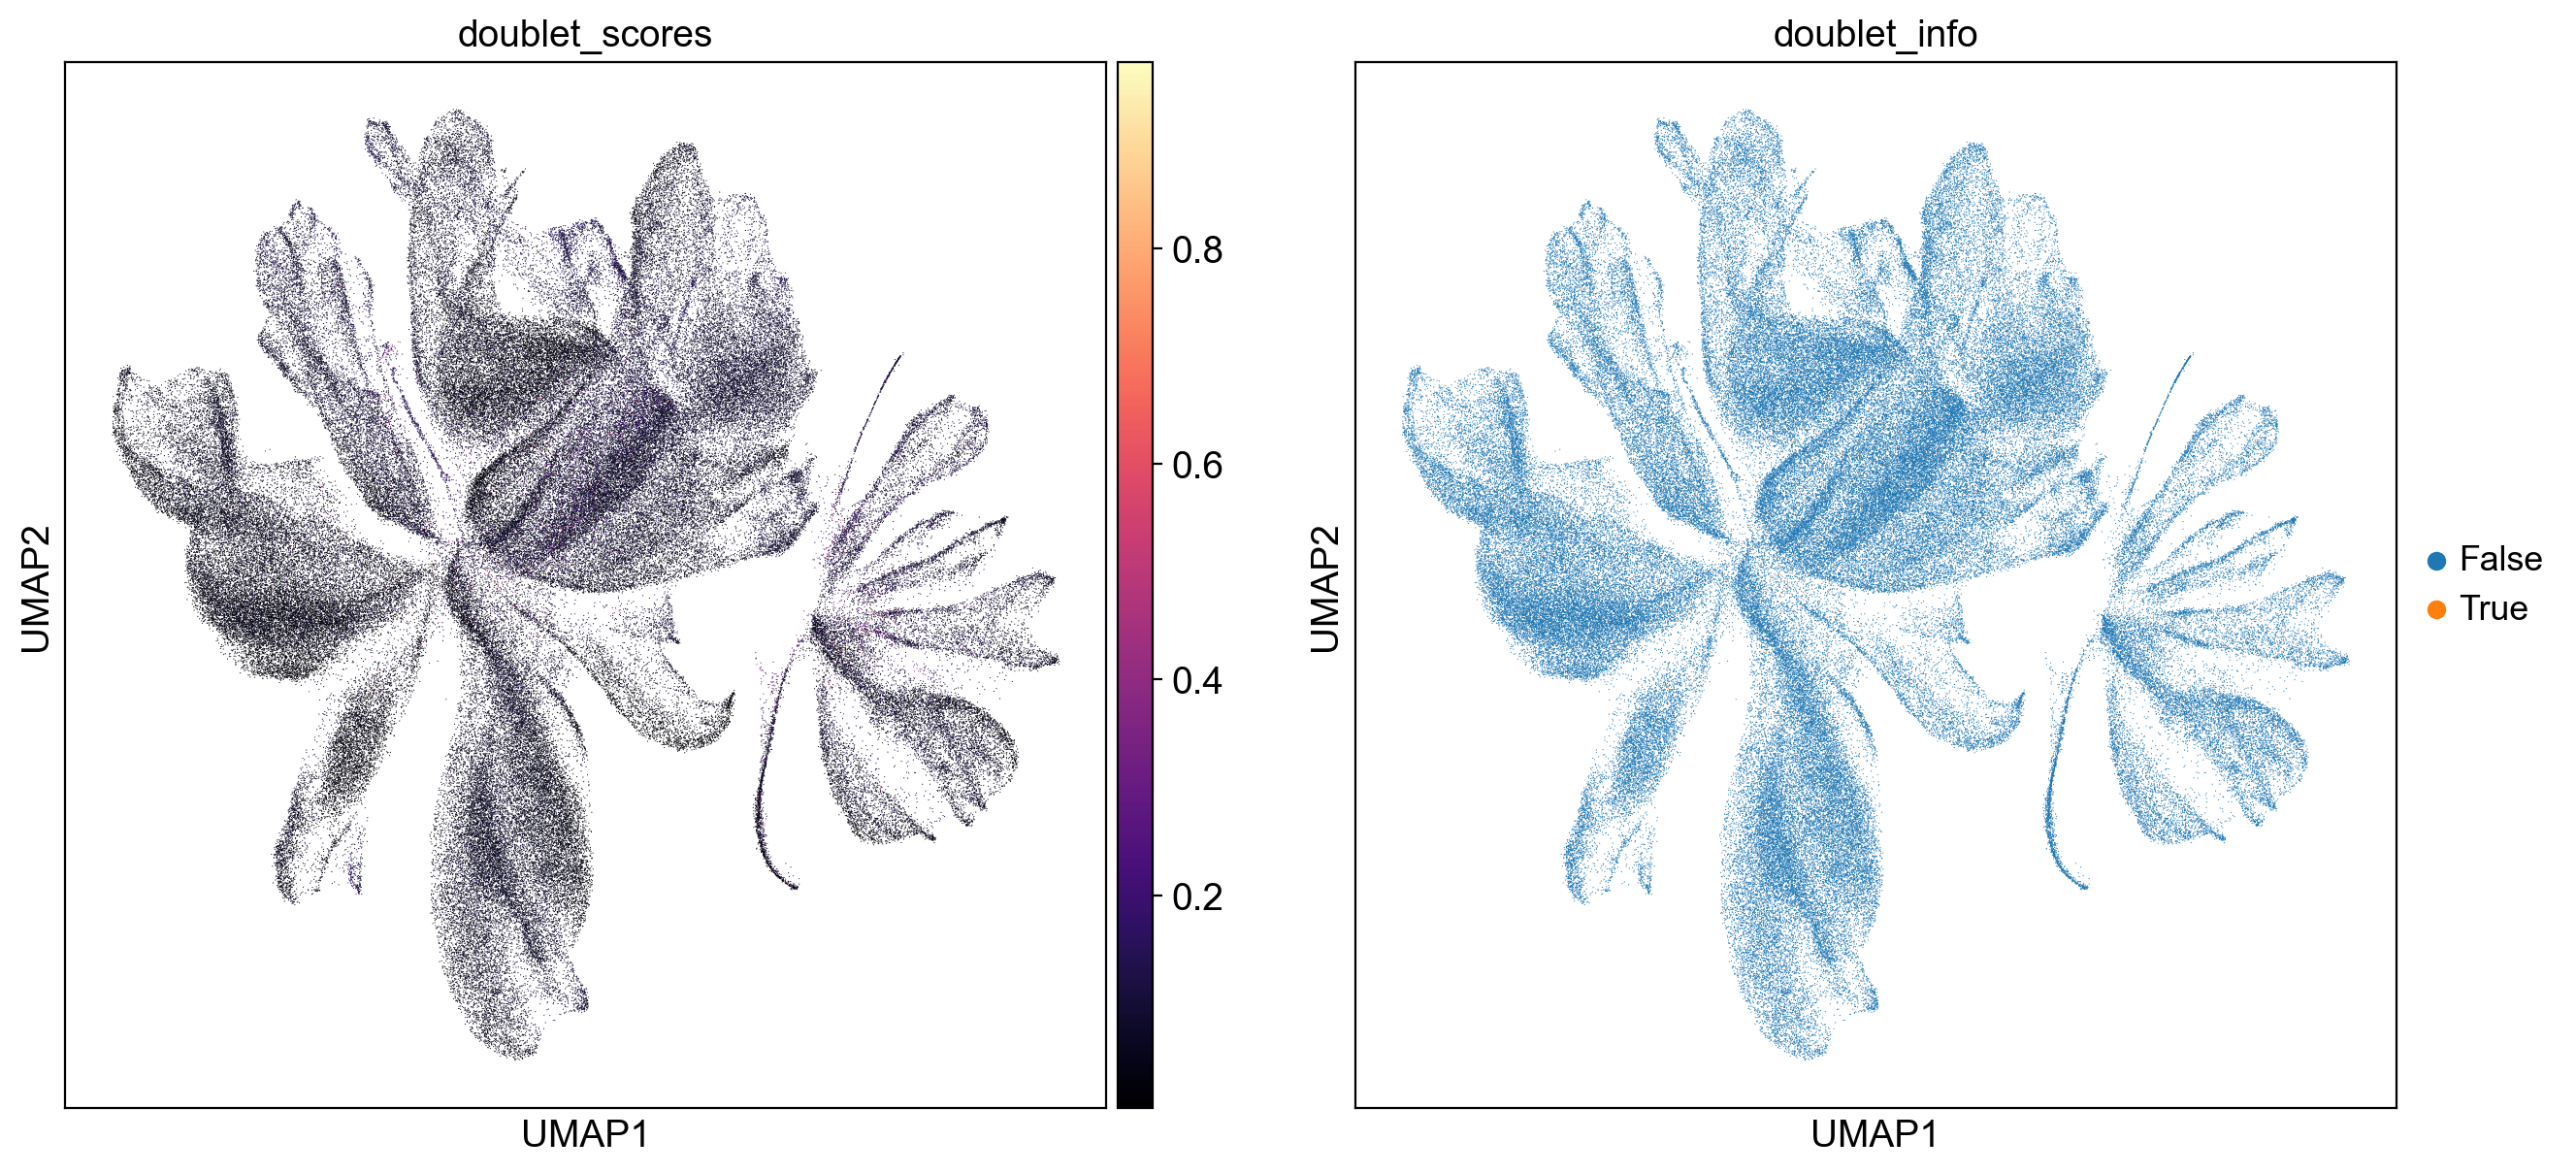

In [ ]:
%matplotlib inline
sc.set_figure_params(figsize=(7, 7),dpi=100)
sc.pl.umap(adata_scrublet, color_map = "magma", color=['doublet_scores','doublet_info'])

In [ ]:
del adata_scrublet

In [ ]:
# Remove doublets from adata
adata = adata[adata.obs['predicted_doublets'] == False]

In [ ]:
adata.obs

cell_type          tissue batch biosample_id  \
cell_id                                                                    
H197396_N1-TCAGCAATCTTTACGT   Stromal           Colon     0   H197396_N1   
H197396_N1-GTAGGCCTCTTCATGT   Stromal           Colon     0   H197396_N1   
H197396_N1-GAGTCCGTCTTTAGGG   Stromal           Colon     0   H197396_N1   
H197396_N1-TGTGTTTCAACAACCT   Stromal           Colon     0   H197396_N1   
H197396_N1-CATCGGGGTAGCACGA   Stromal           Colon     0   H197396_N1   
...                               ...             ...   ...          ...   
H180844_N4-GATCGATCATATACGC    Immune  Terminal Ileum     5   H180844_N4   
H180844_N4-ACTGCTCAGAAACCTA    Immune  Terminal Ileum     5   H180844_N4   
H180844_N4-CATCAGACACGGCCAT    Immune  Terminal Ileum     5   H180844_N4   
H180844_N4-TATGCCCCAATGACCT    Immune  Terminal Ileum     5   H180844_N4   
H180844_N4-ATTATCCCAGCTTAAC    Immune  Terminal Ileum     5   H180844_N4   

                            n_genes n_counts Chem Site  Type donor_id  ...  \
cell_id                                                                ...   
H197396_N1-TCAGCAATCTTTACGT    2635    10265   v2   CO  Heal   197396  ...   
H197396_N1-GTAGGCCTCTTCATGT    2559     8477   v2   CO  Heal   197396  ...   
H197396_N1-GAGTCCGTCTTTAGGG    2334     7392   v2   CO  Heal   197396  ...   
H197396_N1-TGTGTTTCAACAACCT    2320     7314   v2   CO  Heal   197396  ...   
H197396_N1-CATCGGGGTAGCACGA    2234     6959   v2   CO  Heal   197396  ...   
...                             ...      ...  ...  ...   ...      ...  ...   
H180844_N4-GATCGATCATATACGC     101      228   v2   TI  Heal   180844  ...   
H180844_N4-ACTGCTCAGAAACCTA     221      310   v2   TI  Heal   180844  ...   
H180844_N4-CATCAGACACGGCCAT     204      306   v2   TI  Heal   180844  ...   
H180844_N4-TATGCCCCAATGACCT     117      232   v2   TI  Heal   180844  ...   
H180844_N4-ATTATCCCAGCTTAAC     101      168   v2   TI  Heal   180844  ...   

                            pct_counts_in_top_100_genes  \
cell_id                                                   
H197396_N1-TCAGCAATCTTTACGT                   44.237701   
H197396_N1-GTAGGCCTCTTCATGT                   43.954229   
H197396_N1-GAGTCCGTCTTTAGGG                   43.127706   
H197396_N1-TGTGTTTCAACAACCT                   44.503692   
H197396_N1-CATCGGGGTAGCACGA                   43.770657   
...                                                 ...   
H180844_N4-GATCGATCATATACGC                   99.561404   
H180844_N4-ACTGCTCAGAAACCTA                   60.967742   
H180844_N4-CATCAGACACGGCCAT                   66.013072   
H180844_N4-TATGCCCCAATGACCT                   92.672414   
H180844_N4-ATTATCCCAGCTTAAC                   99.404762   

                            pct_counts_in_top_200_genes  \
cell_id                                                   
H197396_N1-TCAGCAATCTTTACGT                   57.554798   
H197396_N1-GTAGGCCTCTTCATGT                   55.691872   
H197396_N1-GAGTCCGTCTTTAGGG                   55.140693   
H197396_N1-TGTGTTTCAACAACCT                   56.193601   
H197396_N1-CATCGGGGTAGCACGA                   56.114384   
...                                                 ...   
H180844_N4-GATCGATCATATACGC                  100.000000   
H180844_N4-ACTGCTCAGAAACCTA                   93.225806   
H180844_N4-CATCAGACACGGCCAT                   98.692810   
H180844_N4-TATGCCCCAATGACCT                  100.000000   
H180844_N4-ATTATCCCAGCTTAAC                  100.000000   

                            pct_counts_in_top_500_genes total_counts_mito  \
cell_id                                                                     
H197396_N1-TCAGCAATCTTTACGT                   71.914272             298.0   
H197396_N1-GTAGGCCTCTTCATGT                   69.847824             623.0   
H197396_N1-GAGTCCGTCTTTAGGG                   70.075758             538.0   
H197396_N1-TGTGTTTCAACAACCT                   70.426579             572.0   
H197396_N1-CATCGGGGTAGCACG